# Introduction
In this notebook we generate plots to evaluate our Input and ChIP samples using output from ChIPQC v1.26.0

# Set Environment
Import the libaries need to handle html formats and data tables

In [1]:
from bs4 import BeautifulSoup # used to parse HTML
import pandas as pd # used to handle dataframes/tables
# used to make plots
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


# categorical ordered type
from pandas.api.types import CategoricalDtype

# stats libary
from scipy import stats
from scipy.stats import mannwhitneyu

the code below is used to parse tables in html

In [2]:
class HTMLTableParser:
       
        def parse_url(self, url):
            soup = BeautifulSoup(url, 'lxml')
            return [(table['id'],self.parse_html_table(table))\
                    for table in soup.find_all('table')]  
    
        def parse_html_table(self, table):
            n_columns = 0
            n_rows=0
            column_names = []
    
            # Find number of rows and columns
            # we also find the column titles if we can
            for row in table.find_all('tr'):
                
                # Determine the number of rows in the table
                td_tags = row.find_all('td')
                if len(td_tags) > 0:
                    n_rows+=1
                    if n_columns == 0:
                        # Set the number of columns for our table
                        n_columns = len(td_tags)
                        
                # Handle column names if we find them
                th_tags = row.find_all('th') 
                if len(th_tags) > 0 and len(column_names) == 0:
                    for th in th_tags:
                        column_names.append(th.get_text().strip())
    
            # Safeguard on Column Titles
            if len(column_names) > 0 and len(column_names) != n_columns:
                raise Exception("Column titles do not match the number of columns")
    
            columns = column_names if len(column_names) > 0 else range(0,n_columns)
            df = pd.DataFrame(columns = columns,
                              index= range(0,n_rows))
            row_marker = 0
            for row in table.find_all('tr'):
                column_marker = 0
                columns = row.find_all('td')
                for column in columns:
                    df.iat[row_marker,column_marker] = column.get_text().strip()
                    column_marker += 1
                if len(columns) > 0:
                    row_marker += 1
                    
            # Convert to float if possible
            for col in df:
                try:
                    df[col] = df[col].astype(float)
                except ValueError:
                    pass
            
            return df

hard-code the location of the ChIPQC results within the Github repo

In [3]:
indir="../data/ChIPQCreport"

# Summary Tables

## Input-Seq (20 Random Inputs)

In [4]:
input_names=["noMask","GS","BL"]
input_dir=["20inputs_noMask",
              "20inputs_gsMask",
              "20inputs_blMask"]
input_summary_df=None
for i in range(0,len(input_names)):
    iname = input_names[i]
    ichipqc = ("%s/%s/ChIPQC.html" % (indir,input_dir[i]))
    hp = HTMLTableParser()
    with open(ichipqc, 'r') as f:

        contents = f.read()

        soup = BeautifulSoup(contents, "html.parser")

        i_summary_table = soup.find_all('table')[0]
        i_summary_df = hp.parse_html_table(i_summary_table)
        i_summary_df["mask"]=iname
        if i == 0:
            input_summary_df = i_summary_df.copy()
        else:
            input_summary_df = input_summary_df.append(
                i_summary_df, ignore_index=True)

### SSD boxplot

/home/sklasfeld/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


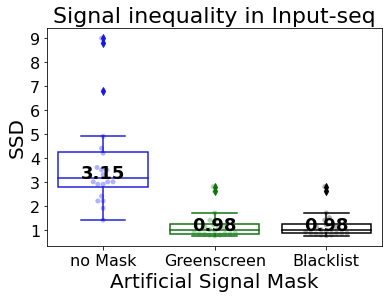

In [5]:
# change mask labels
input_summary_df = (
    input_summary_df.replace(
    ["GS","noMask","BL"],["Greenscreen","no Mask","Blacklist"]))


mask_cat_type = CategoricalDtype(categories=["no Mask", "Greenscreen","Blacklist"], ordered=True)
input_summary_df["mask"] = input_summary_df["mask"].astype(mask_cat_type)
input_summary_df["mask"].cat.remove_unused_categories(inplace=True)

fig,(ax1) = plt.subplots(1)


font = {'size'   : 15}

plt.rc('font', **font)

# generate boxplot
box_plot = sns.boxplot(x="mask", y="SSD", 
                 palette=sns.color_palette(["blue","green","black"]),
                 data=input_summary_df, ax=ax1)
# use swarmplot() to show the data points on top of the box plots
sns.swarmplot(x="mask", y="SSD", data=input_summary_df, 
              palette=sns.color_palette(["blue","green","black"]),
             ax=ax1, alpha=0.3)
# label each integer on the y-axis
ax1.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.yaxis.set_major_formatter(ticker.ScalarFormatter())
# set title and x label
ax1.set_title('Signal inequality in Input-seq',fontsize=22)
ax1.set_xlabel('Artificial Signal Mask',fontsize=20)
ax1.set_ylabel('SSD',fontsize=20)
ax1.tick_params(labelsize=16)


for i,artist in enumerate(ax1.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor(col)
    artist.set_facecolor('None')

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax1.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)
        
medians = input_summary_df.groupby(['mask'])['SSD'].median()
vertical_offset = input_summary_df['SSD'].median() * 0.01 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,np.round(medians[xtick],2), 
            horizontalalignment='center',size='large',color='k',weight='semibold')

## Statistical Testing
We are interested in comparing whether SSD valus are statisically equal before and after masking artificial signals with greenscreen or blacklist. First let us plot the distributions of the three groups.

/home/sklasfeld/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


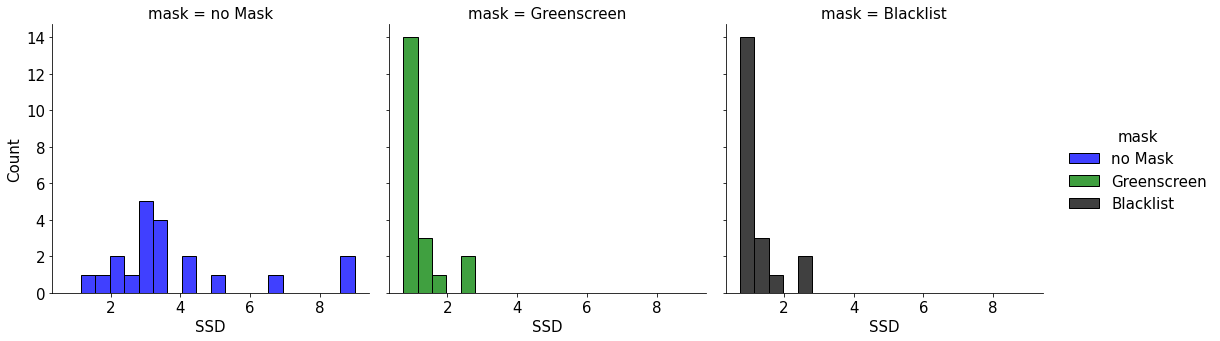

In [6]:
sns.displot(col="mask", x="SSD", hue="mask", ax=ax1, 
                 palette=sns.color_palette(["blue","green","black"]),
                 data=input_summary_df, bins=20)
plt.show()

It is hard to tell whether they both have normal distributions so let us get more information about the mean and standard deviation.

In [7]:
noMask_ssd_series = input_summary_df.loc[input_summary_df["mask"]=="no Mask","SSD"]
noMask_ssd_series.describe()

count    20.000000
mean      3.845000
std       2.092461
min       1.400000
25%       2.775000
50%       3.150000
75%       4.250000
max       9.000000
Name: SSD, dtype: float64

In [8]:
gs_ssd_series = input_summary_df.loc[input_summary_df["mask"]=="Greenscreen","SSD"]
gs_ssd_series.describe()

count    20.000000
mean      1.186000
std       0.576015
min       0.740000
25%       0.840000
50%       0.975000
75%       1.250000
max       2.800000
Name: SSD, dtype: float64

In [9]:
bl_ssd_series = input_summary_df.loc[input_summary_df["mask"]=="Blacklist","SSD"]
bl_ssd_series.describe()

count    20.000000
mean      1.189500
std       0.577431
min       0.750000
25%       0.850000
50%       0.980000
75%       1.250000
max       2.800000
Name: SSD, dtype: float64

Observations
* The variance in the no mask group is different from the variance in mask groups
* The medians show that the masked data is skewed to the left and not normally distributed

In [10]:
stat, p = mannwhitneyu(gs_ssd_series, 
                     noMask_ssd_series,
                    alternative="less",
                    use_continuity=True)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

Statistics=12.000, p=0.000
Different distribution (reject H0)


In [11]:
stat, p = mannwhitneyu(bl_ssd_series, 
                     noMask_ssd_series,
                    alternative="less",
                    use_continuity=True)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

Statistics=12.500, p=0.000
Different distribution (reject H0)


## ChIP-Seq (LFY, FD, and TFL1)

In [12]:
mask_list=["noMask","gsMask","blMask"]
mask_dic={"noMask":"noMask", 
          "gsMask":"GS",
          "blMask":"BL"}
dup_list=["wiDups"]
macs2_controls_list=["bestControlsV5"]

all_chip_summary_df=None
i=0
for mask in mask_list:
    for dup in dup_list:
        for mcontrol in macs2_controls_list:
            subdir=("chip_%s_%s_%s_extFragSize_qval10" % (mask, dup, mcontrol))
            chipqc_html = ("%s/%s/ChIPQC.html" % (indir,subdir))
            hp = HTMLTableParser()
            with open(chipqc_html, 'r') as f:
                contents = f.read()
                soup = BeautifulSoup(contents, "html.parser")

                chip_summary_table = soup.find_all('table')[0]
                chip_summary_df = hp.parse_html_table(chip_summary_table)
                chip_summary_df["mask"]=mask_dic[mask]
                chip_summary_df["dup"]=dup
                chip_summary_df["macs2_control"]=mcontrol
                if i == 0:
                    all_chip_summary_df = chip_summary_df.copy()
                else:
                    all_chip_summary_df = all_chip_summary_df.append(
                        chip_summary_df, ignore_index=True)
            i+=1

In [13]:
TFL1_A_W_chipSummary_df = (
    all_chip_summary_df.loc[((all_chip_summary_df["ID"].str.contains("TFL1_A_W")) &
                         (all_chip_summary_df["macs2_control"]=="bestControlsV5")),:])

Text(0, 0.5, 'RSC')

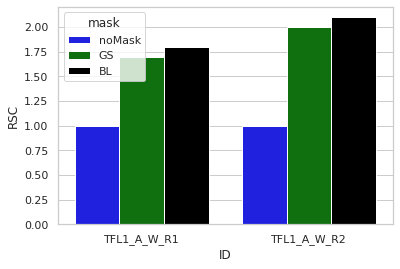

In [14]:
sns.set(font_scale=1.2)
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="ID", y="RelCC", 
                 hue="mask",
                 data=TFL1_A_W_chipSummary_df,
                 palette=sns.color_palette(["blue","green","black"]))
ax.set_ylabel("RSC")
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [15]:
if 1==0:
    sns.set(font_scale=1.2)
    g = sns.FacetGrid(TFL1_A_W_chipSummary_df, col="ID")
    g.map_dataframe(sns.barplot, x="ID", y="RelCC", 
                    hue="mask",
                    palette=sns.color_palette(["blue","green","black"]))
    g.set_axis_labels("", "RSC")
    g.set_titles(col_template="{col_name}")
    g.add_legend()

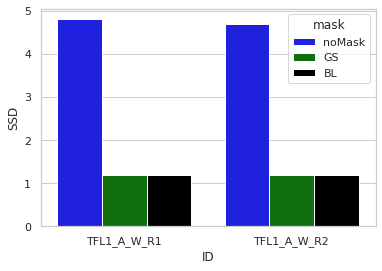

In [16]:
sns.set(font_scale=1.2)
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="ID", y="SSD", 
                 hue="mask",
                 data=TFL1_A_W_chipSummary_df,
                 palette=sns.color_palette(["blue","green","black"]))
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)